<a href="https://colab.research.google.com/github/wose70/HDB_Rental/blob/main/01_refined_hdb_rental_prediction_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Refined Project 1: Advanced HDB Rental Price Prediction (Fixed)

## Features:
- Data cleaning and handling missing values
- Temporal analysis
- Advanced feature engineering
- Multiple models comparison
- Cross-validation
- Interactive visualizations

In [10]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [11]:
# 2. Load and Prepare Data
def load_data():
    # Load datasets
    rentals = pd.read_csv('RentingOutofFlats2025.csv')

    # Convert rent_approval_date to datetime
    rentals['rent_approval_date'] = pd.to_datetime(rentals['rent_approval_date'])

    return rentals

data = load_data()
current_date = pd.to_datetime('2025-05-09')

# Display initial data info
print("Dataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155464 entries, 0 to 155463
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   rent_approval_date  155464 non-null  datetime64[ns]
 1   town                155464 non-null  object        
 2   block               155464 non-null  object        
 3   street_name         155464 non-null  object        
 4   flat_type           155464 non-null  object        
 5   monthly_rent        155464 non-null  int64         
 6   region              673 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 8.3+ MB
None

Missing Values:
rent_approval_date         0
town                       0
block                      0
street_name                0
flat_type                  0
monthly_rent               0
region                154791
dtype: int64


In [12]:
# 3. Feature Engineering
def engineer_features(data, current_date):
    # Temporal features
    data['days_since_approval'] = (current_date - data['rent_approval_date']).dt.days
    data['month'] = data['rent_approval_date'].dt.month
    data['year'] = data['rent_approval_date'].dt.year

    # Extract number of rooms from flat_type
    def extract_rooms(flat_type):
        if pd.isna(flat_type):
            return np.nan
        if 'EXECUTIVE' in flat_type:
            return 6
        num = ''.join(filter(str.isdigit, flat_type))
        return float(num) if num else np.nan

    data['rooms'] = data['flat_type'].apply(extract_rooms)

    return data

data = engineer_features(data, current_date)

# Check engineered features
print("\nEngineered Features:")
print(data[['days_since_approval', 'month', 'year', 'rooms']].describe())


Engineered Features:
       days_since_approval          month           year          rooms
count        155464.000000  155464.000000  155464.000000  155464.000000
mean            833.806386       6.141705    2022.642033       3.978169
std             454.807305       3.499749       1.253214       0.932542
min              69.000000       1.000000    2021.000000       1.000000
25%             434.000000       3.000000    2021.000000       3.000000
50%             828.000000       6.000000    2023.000000       4.000000
75%            1255.000000       9.000000    2024.000000       5.000000
max            1589.000000      12.000000    2025.000000       6.000000


In [13]:
# 4. Data Cleaning and Preprocessing
def preprocess_data(data):
    # Select features
    feature_cols = ['town', 'rooms', 'flat_type', 'month', 'days_since_approval']

    # Create X and y
    X = data[feature_cols].copy()
    y = data['monthly_rent']

    # Handle categorical variables
    categorical_cols = ['town', 'flat_type']
    for col in categorical_cols:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Create preprocessing pipeline
    numeric_features = ['rooms', 'month', 'days_since_approval']

    # Impute missing values and scale features
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Fit and transform the training data
    X_train_transformed = pipeline.fit_transform(X_train)
    X_test_transformed = pipeline.transform(X_test)

    return X_train_transformed, X_test_transformed, y_train, y_test, feature_cols, pipeline

X_train_transformed, X_test_transformed, y_train, y_test, feature_cols, pipeline = preprocess_data(data)

In [14]:
# 5. Model Training and Evaluation
def train_and_evaluate_models():
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }

    results = {}
    for name, model in models.items():
        # Train model
        model.fit(X_train_transformed, y_train)

        # Make predictions
        y_pred = model.predict(X_test_transformed)

        # Calculate metrics
        results[name] = {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }

        # Cross-validation score
        cv_scores = cross_val_score(model, X_train_transformed, y_train,
                                   cv=5, scoring='r2')
        results[name]['CV_R2'] = cv_scores.mean()

    return pd.DataFrame(results).T

model_results = train_and_evaluate_models()
print("Model Performance Comparison:")
print(model_results)

Model Performance Comparison:
                         RMSE         MAE        R2     CV_R2
Linear Regression  579.375010  441.488519  0.413249  0.420686
Ridge              579.375006  441.488614  0.413249  0.420686
Lasso              579.376284  441.494580  0.413247  0.420679
Random Forest      516.058896  390.409101  0.534486  0.529321
Gradient Boosting  515.175574  390.505682  0.536078  0.538512


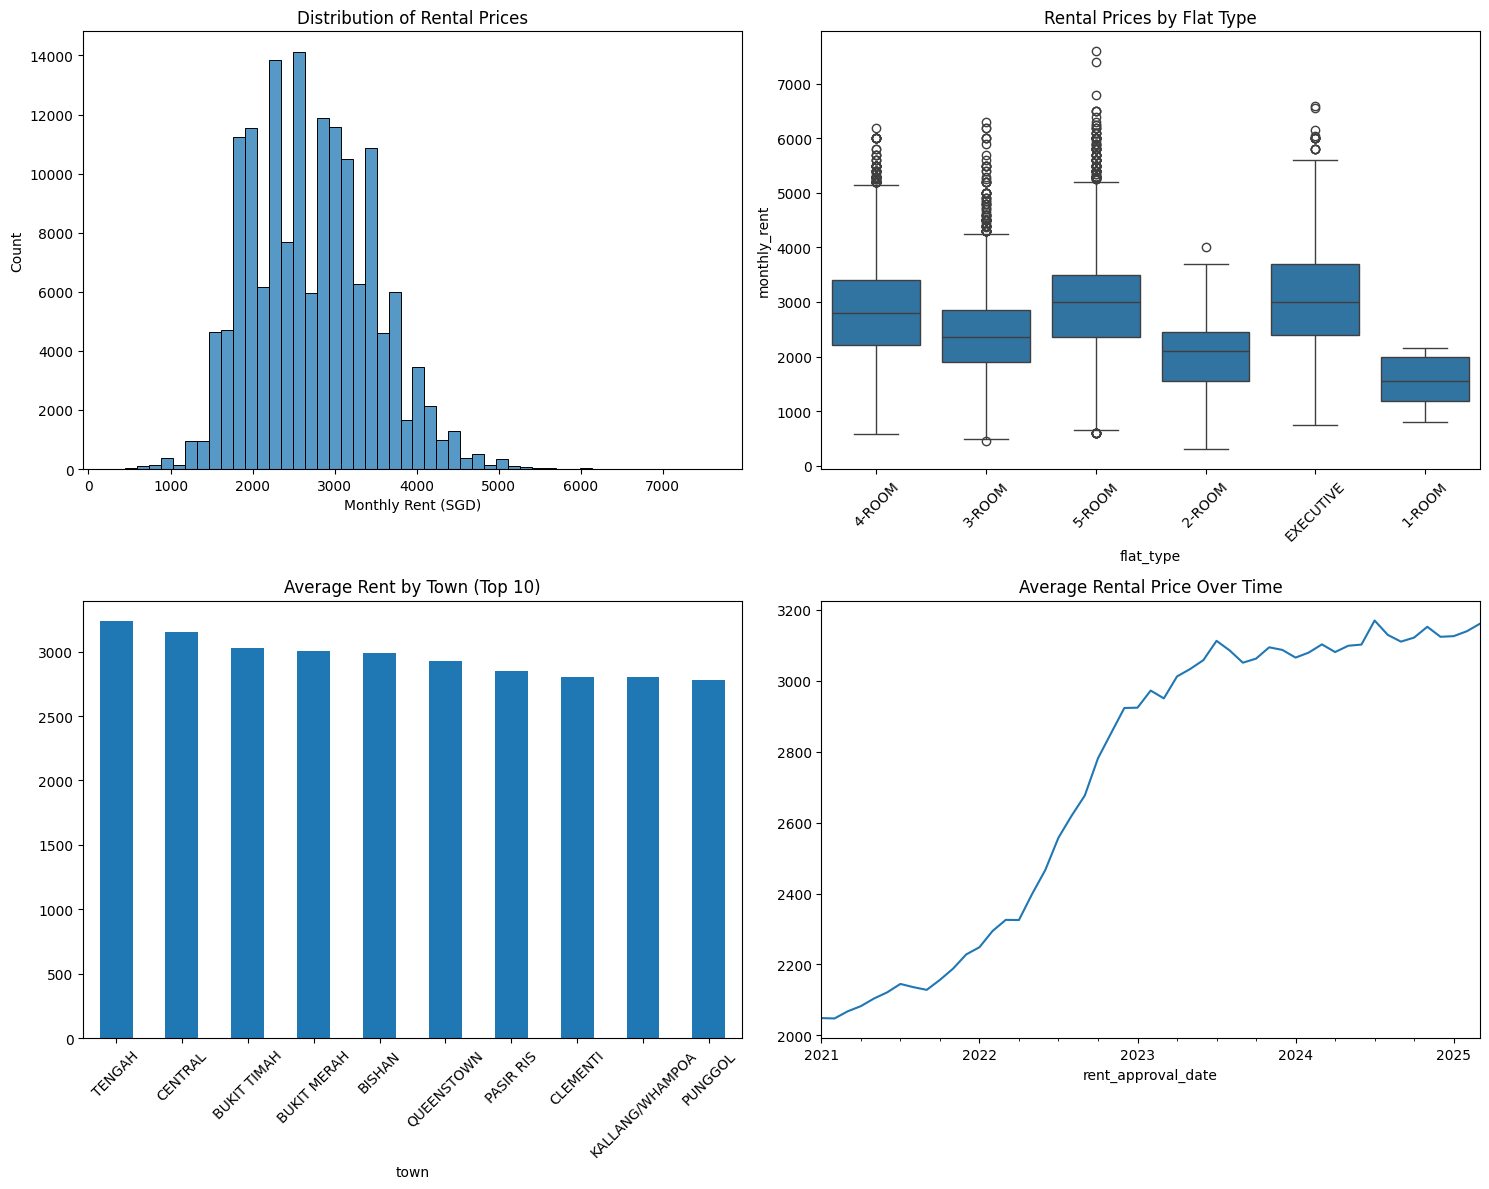

In [15]:
# 6. Visualization
def plot_analysis(data):
    # Set up the plotting style
    # plt.style.use('seaborn')

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Rental Price Distribution
    sns.histplot(data=data, x='monthly_rent', bins=50, ax=axes[0,0])
    axes[0,0].set_title('Distribution of Rental Prices')
    axes[0,0].set_xlabel('Monthly Rent (SGD)')

    # 2. Rental by Flat Type
    sns.boxplot(data=data, x='flat_type', y='monthly_rent', ax=axes[0,1])
    axes[0,1].set_title('Rental Prices by Flat Type')
    axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)

    # 3. Average Rent by Town (Top 10)
    town_avg = data.groupby('town')['monthly_rent'].mean().sort_values(ascending=False).head(10)
    town_avg.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Average Rent by Town (Top 10)')
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)

    # 4. Time Series of Average Rent
    monthly_avg = data.groupby('rent_approval_date')['monthly_rent'].mean()
    monthly_avg.plot(ax=axes[1,1])
    axes[1,1].set_title('Average Rental Price Over Time')

    plt.tight_layout()
    plt.show()

plot_analysis(data)

In [19]:
# 7. Prediction Function
def predict_rental_price(town, flat_type, month, feature_cols, pipeline, models):  # Pass models
    # Create a sample input with the correct order of features
    input_data = pd.DataFrame([[town, extract_rooms(flat_type), flat_type, month, 0]],
                              columns=feature_cols)

    # Encode categorical variables
    input_data['town'] = LabelEncoder().fit_transform(input_data['town'].astype(str))
    input_data['flat_type'] = LabelEncoder().fit_transform(input_data['flat_type'].astype(str))

    # Transform features
    input_transformed = pipeline.transform(input_data)

    # Get predictions from all models
    predictions = {}
    for name, model in models.items():
        pred = model.predict(input_transformed)[0]
        predictions[name] = round(pred, 2)

    return predictions

# Train and evaluate models once outside the prediction function
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Train all models
for name, model in models.items():
    model.fit(X_train_transformed, y_train)

# Example prediction, passing feature_cols, pipeline, and models
sample_prediction = predict_rental_price(
    town='ANG MO KIO',
    flat_type='4-ROOM',
    month=5,
    feature_cols=feature_cols,  # Pass feature_cols
    pipeline=pipeline,  # Pass pipeline
    models=models  # Pass the trained models dictionary
)
print("\nPredicted monthly rent for 4-ROOM flat in ANG MO KIO:")
for model, price in sample_prediction.items():
    print(f"{model}: ${price:,.2f}")


Predicted monthly rent for 4-ROOM flat in ANG MO KIO:
Linear Regression: $3,096.53
Ridge: $3,096.52
Lasso: $3,539.86
Random Forest: $2,745.35
Gradient Boosting: $2,677.01
